In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

## Datos Comandos

In [2]:
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 8)

excel_path = r"Data\2dos\UR5B_Datos.xlsx"


# Cargar hojas
df_datos_controlador = pd.read_excel(excel_path, sheet_name='Datos_Controlador')
df_entrada_cinematica = pd.read_excel(excel_path, sheet_name='Coord_Cartesianas')
df_salida_cinematica = pd.read_excel(excel_path, sheet_name='Pos_Articulares')
df_fuerza_xyz = pd.read_excel(excel_path, sheet_name='Fuerza_XYZ')
df_momento_xyz = pd.read_excel(excel_path, sheet_name='Momento_XYZ')

#  Concatenar entrada en t+1 y t (t-actual se marca con _prev)
df_entrada_t1 = df_entrada_cinematica.shift(-1).iloc[:-1].reset_index(drop=True)
df_entrada_t = df_entrada_cinematica.iloc[:-1].reset_index(drop=True)
df_entrada_t.columns = [f"{col}_prev" for col in df_entrada_t.columns]
df_entrada = pd.concat([df_entrada_t1, df_entrada_t], axis=1)

# Concatenar salida en t+1 y t
df_salida_t1 = df_salida_cinematica.shift(-1).iloc[:-1].reset_index(drop=True)
df_salida_t = df_salida_cinematica.iloc[:-1].reset_index(drop=True)
df_salida_t.columns = [f"{col}_prev" for col in df_salida_t.columns]
df_salida = pd.concat([df_salida_t1, df_salida_t], axis=1)

# Formar el DataFrame principal de entrada+salida
df = pd.concat([df_entrada, df_salida], axis=1)

# Calcular diferencias para fuerza y momento (delta)
df_fuerza_delta = df_fuerza_xyz.diff().iloc[1:].reset_index(drop=True)
df_fuerza_delta.columns = [f"{col}_delta" for col in df_fuerza_delta.columns]

df_momento_delta = df_momento_xyz.diff().iloc[1:].reset_index(drop=True)
df_momento_delta.columns = [f"{col}_delta" for col in df_momento_delta.columns]

# Comando en t+1 sin diferencias
df_comando = df_datos_controlador["Comando"].shift(-1).iloc[1:].reset_index(drop=True)

# Concatenar covariables
df_cov = pd.concat([df_fuerza_delta, df_momento_delta, df_comando], axis=1)
df_cov.columns = list(df_fuerza_delta.columns) + list(df_momento_delta.columns) + ['Comando']

# Concatenar todo: entrada, salida y covariables
df_dos = pd.concat([df.reset_index(drop=True), df_cov], axis=1)

# Eliminar duplicados
df_dos = df_dos.drop_duplicates().reset_index(drop=True)

# Codificación dummy de comando, usando 10 como base redundante
df_comando_dummy = pd.get_dummies(df_dos["Comando"], prefix="Comando", drop_first=True)
df_final = pd.concat([df_dos.drop(columns=["Comando"]), df_comando_dummy], axis=1)

# Renombrar columnas Q1-Q6 y Q1_prev-Q6_prev a q0-q5 y q0_prev-q5_prev en df_final
rename_dict = {f"Q{i+1}": f"q{i}" for i in range(6)}
rename_dict.update({f"Q{i+1}_prev": f"q{i}_prev" for i in range(6)})
df_final.rename(columns=rename_dict, inplace=True)

# Guardar
df_final.to_csv(r"Data\2dos\datos_comandos.csv", index=False)



In [3]:
df_final

,X,Y,Z,RX,RY,RZ,X_prev,Y_prev,Z_prev,RX_prev,...,Momento_Y_delta,Momento_Z_delta,Comando_911.0,Comando_912.0,Comando_913.0,Comando_914.0,Comando_915.0,Comando_916.0,Comando_917.0,Comando_918.0
0,0.393,-0.099,0.541,0.011,-3.129,0.008,0.393,-0.099,0.541,0.011,...,0.000,0.000,False,False,False,False,False,False,False,False
1,0.393,-0.099,0.541,0.010,-3.129,0.008,0.393,-0.099,0.541,0.011,...,0.010,-0.002,False,False,False,False,False,False,False,False
2,0.393,-0.099,0.541,0.010,-3.129,0.008,0.393,-0.099,0.541,0.010,...,0.000,0.000,False,False,False,False,False,False,False,False
3,0.393,-0.099,0.541,0.010,-3.129,0.008,0.393,-0.099,0.541,0.010,...,-0.020,0.008,False,False,False,False,False,False,False,False
4,0.393,-0.099,0.541,0.010,-3.129,0.008,0.393,-0.099,0.541,0.010,...,0.018,-0.002,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47056,-0.101,-0.133,1.079,0.003,0.002,-1.584,-0.101,-0.133,1.079,0.003,...,-0.003,0.000,False,False,False,True,False,False,False,False
47057,-0.101,-0.133,1.079,0.003,0.002,-1.584,-0.101,-0.133,1.079,0.003,...,0.006,0.002,False,False,False,True,False,False,False,False
47058,-0.101,-0.133,1.079,0.003,0.002,-1.584,-0.101,-0.133,1.079,0.003,...,-0.008,0.000,False,False,False,True,False,False,False,False
47059,-0.101,-0.133,1.079,0.003,0.002,-1.584,-0.101,-0.133,1.079,0.003,...,0.004,0.003,False,False,False,True,False,False,False,False


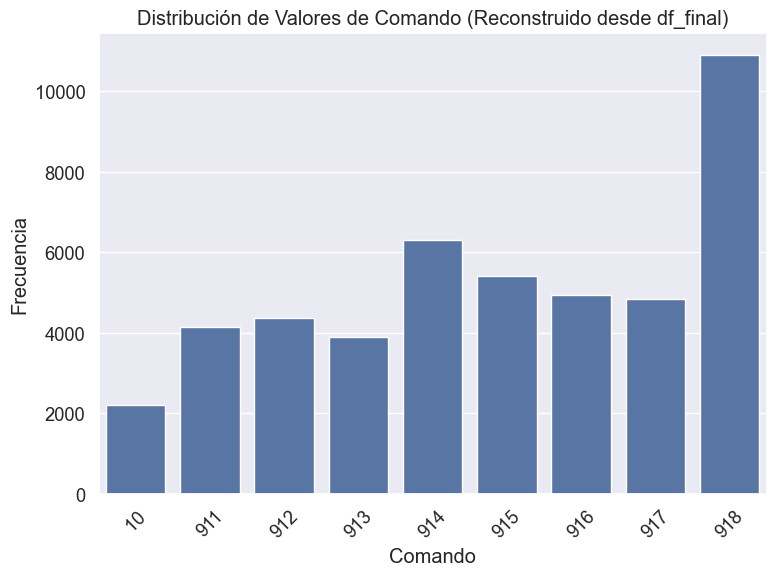

In [4]:
cols_dummy = [col for col in df_final.columns if col.startswith("Comando_")]

df_comando = df_final[cols_dummy].copy()
comando_labels = {col: int(col.split("_")[1].split(".")[0]) for col in cols_dummy}
df_comando["Comando"] = df_comando.idxmax(axis=1).map(comando_labels)
df_comando.loc[df_comando[cols_dummy].sum(axis=1) == 0, "Comando"] = 10
comando_counts = df_comando["Comando"].value_counts().sort_index()

plt.figure(figsize=(8, 6))
sns.barplot(x=comando_counts.index, y=comando_counts.values)
plt.title("Distribución de Valores de Comando (Reconstruido desde df_final)")
plt.xlabel("Comando")
plt.ylabel("Frecuencia")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




- 918 presenta un desbalanceo a favor muy grande.

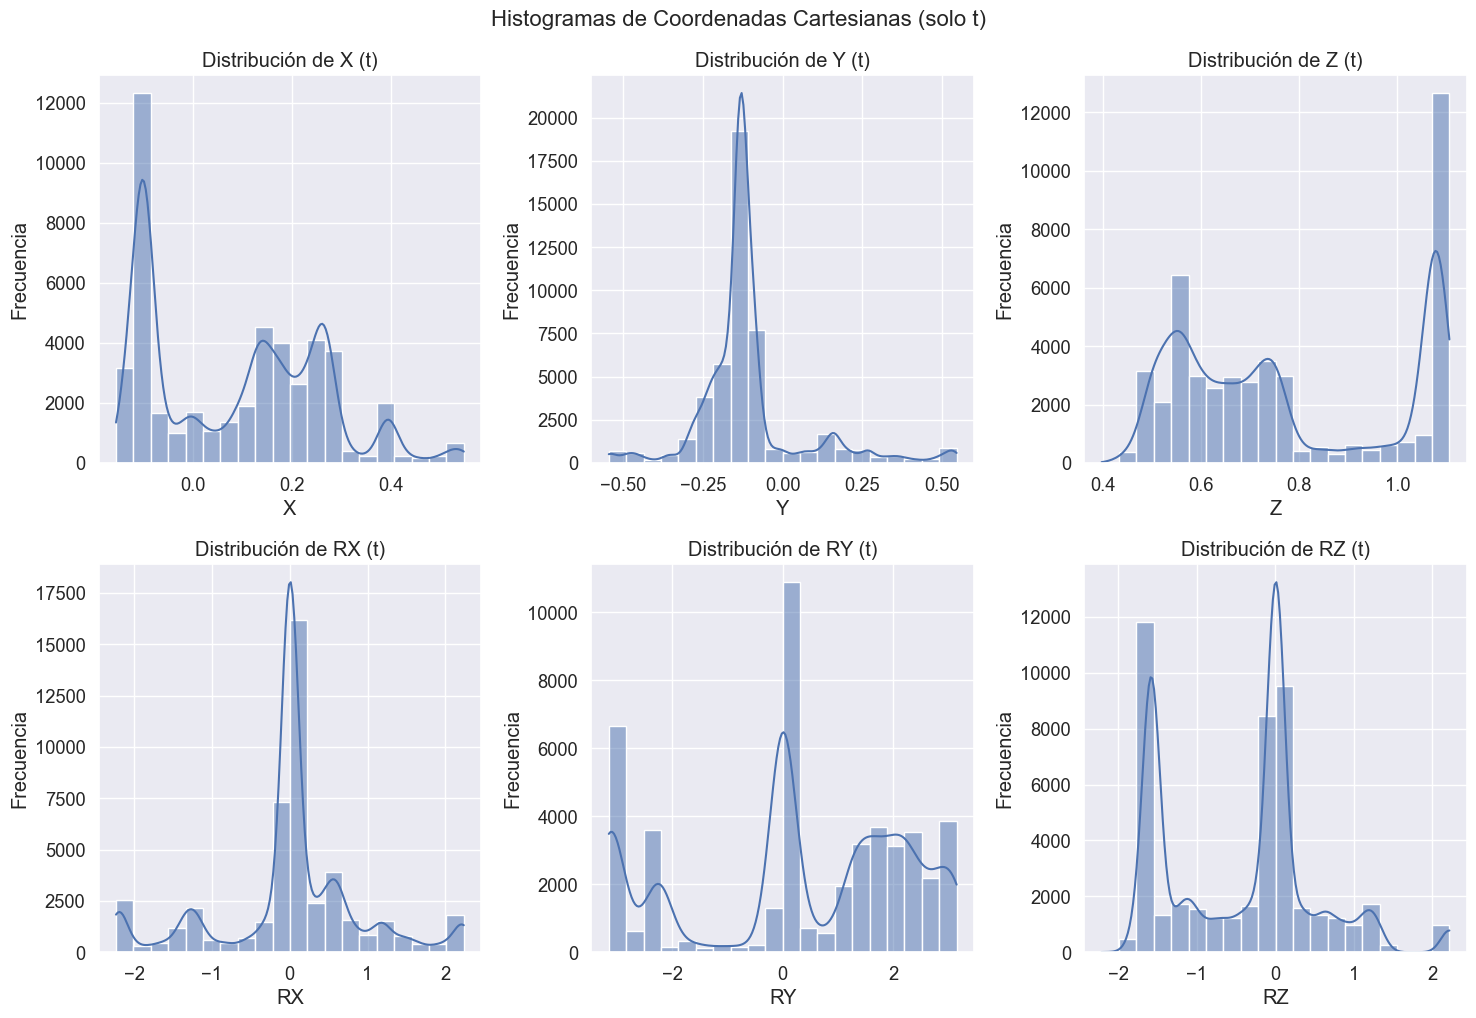

In [5]:
def plot_cartesian_histograms(df):
    variables = ['X', 'Y', 'Z', 'RX', 'RY', 'RZ']
    positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 3, figure=fig)

    for var, pos in zip(variables, positions):
        if var in df.columns:
            ax = fig.add_subplot(gs[pos])
            sns.histplot(df[var], kde=True, ax=ax, bins=20)
            ax.set_title(f'Distribución de {var} (t)')
            ax.set_xlabel(var)
            ax.set_ylabel('Frecuencia')
        else:
            print(f"Variable {var} no encontrada en el DataFrame")

    plt.tight_layout()
    plt.suptitle('Histogramas de Coordenadas Cartesianas (solo t)', fontsize=16, y=1.02)
    plt.show()

plot_cartesian_histograms(df_final)

Existe posibilidad de posciones repetidas. 

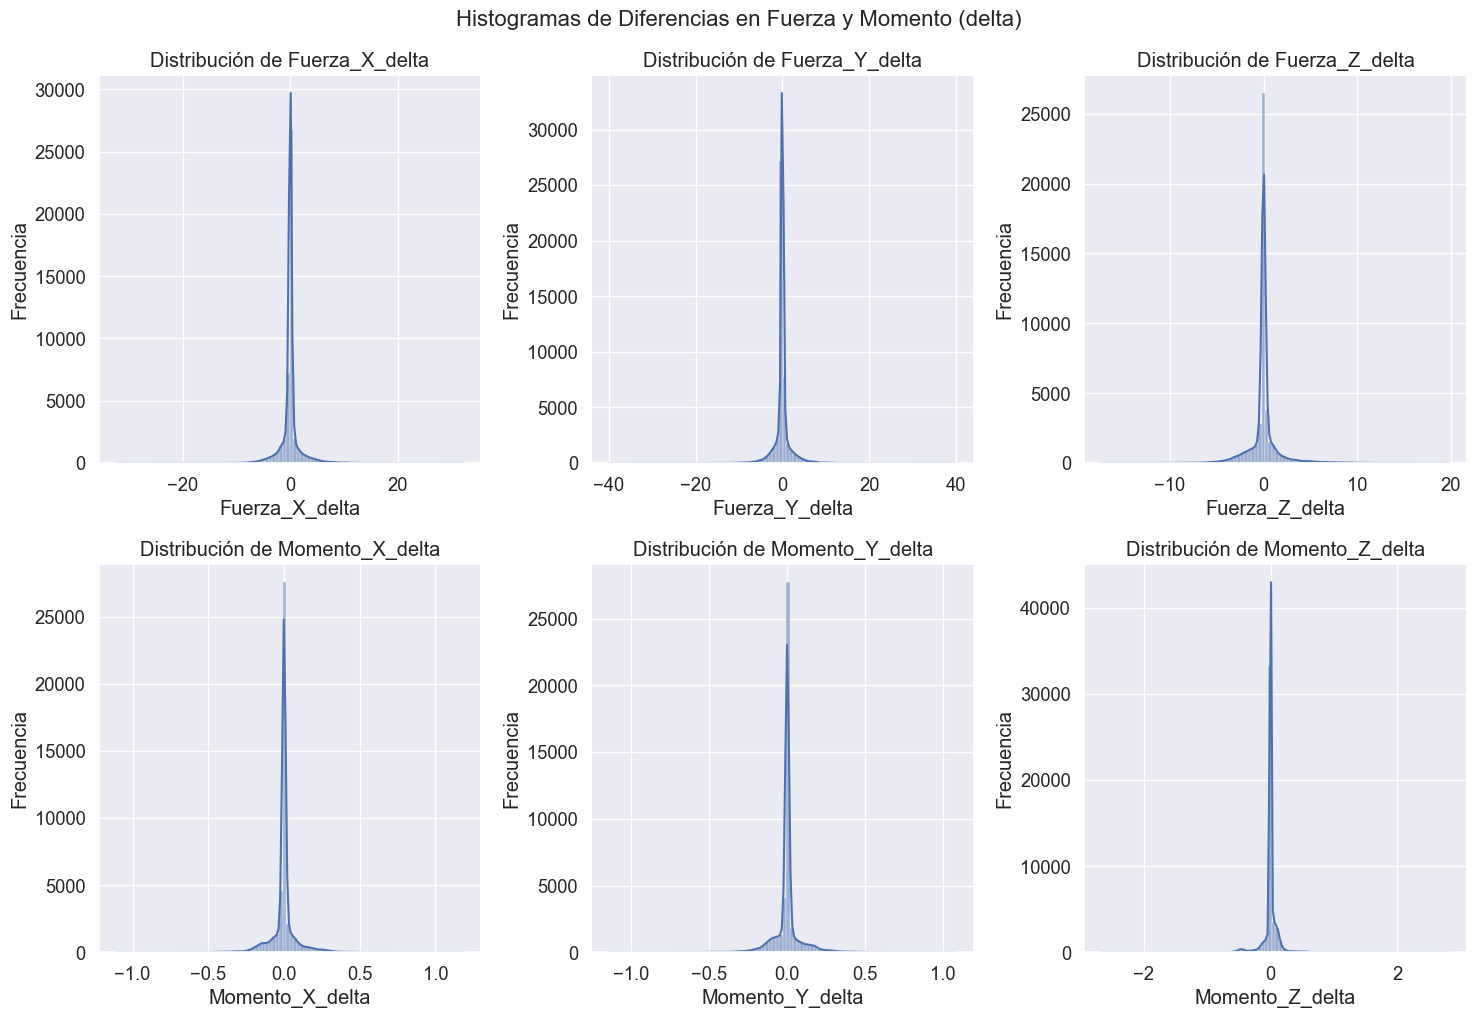

In [6]:

variables_fuerza = ['Fuerza_X_delta', 'Fuerza_Y_delta', 'Fuerza_Z_delta']
variables_momento = ['Momento_X_delta', 'Momento_Y_delta', 'Momento_Z_delta']
positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 3, figure=fig)

for i, (var, pos) in enumerate(zip(variables_fuerza + variables_momento, positions)):
    ax = fig.add_subplot(gs[pos])
    if var in df_final.columns:
        sns.histplot(df_final[var], kde=True, ax=ax, bins=100)
        ax.set_title(f'Distribución de {var}')
        ax.set_xlabel(var)
        ax.set_ylabel('Frecuencia')
    else:
        print(f"Variable {var} no encontrada en df_final")

plt.tight_layout()
plt.suptitle('Histogramas de Diferencias en Fuerza y Momento (delta)', fontsize=16, y=1.02)
plt.show()


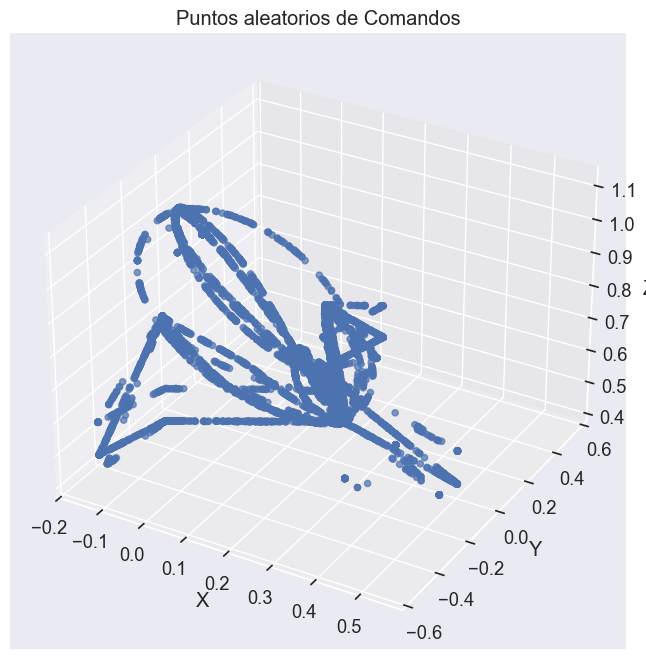

In [28]:
n = 10000
df_sample = df_final.sample(n=n, random_state=42) if len(df) > n else df_final
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_sample['X'], df_sample['Y'], df_sample['Z'], alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Puntos aleatorios de Comandos')
plt.show()


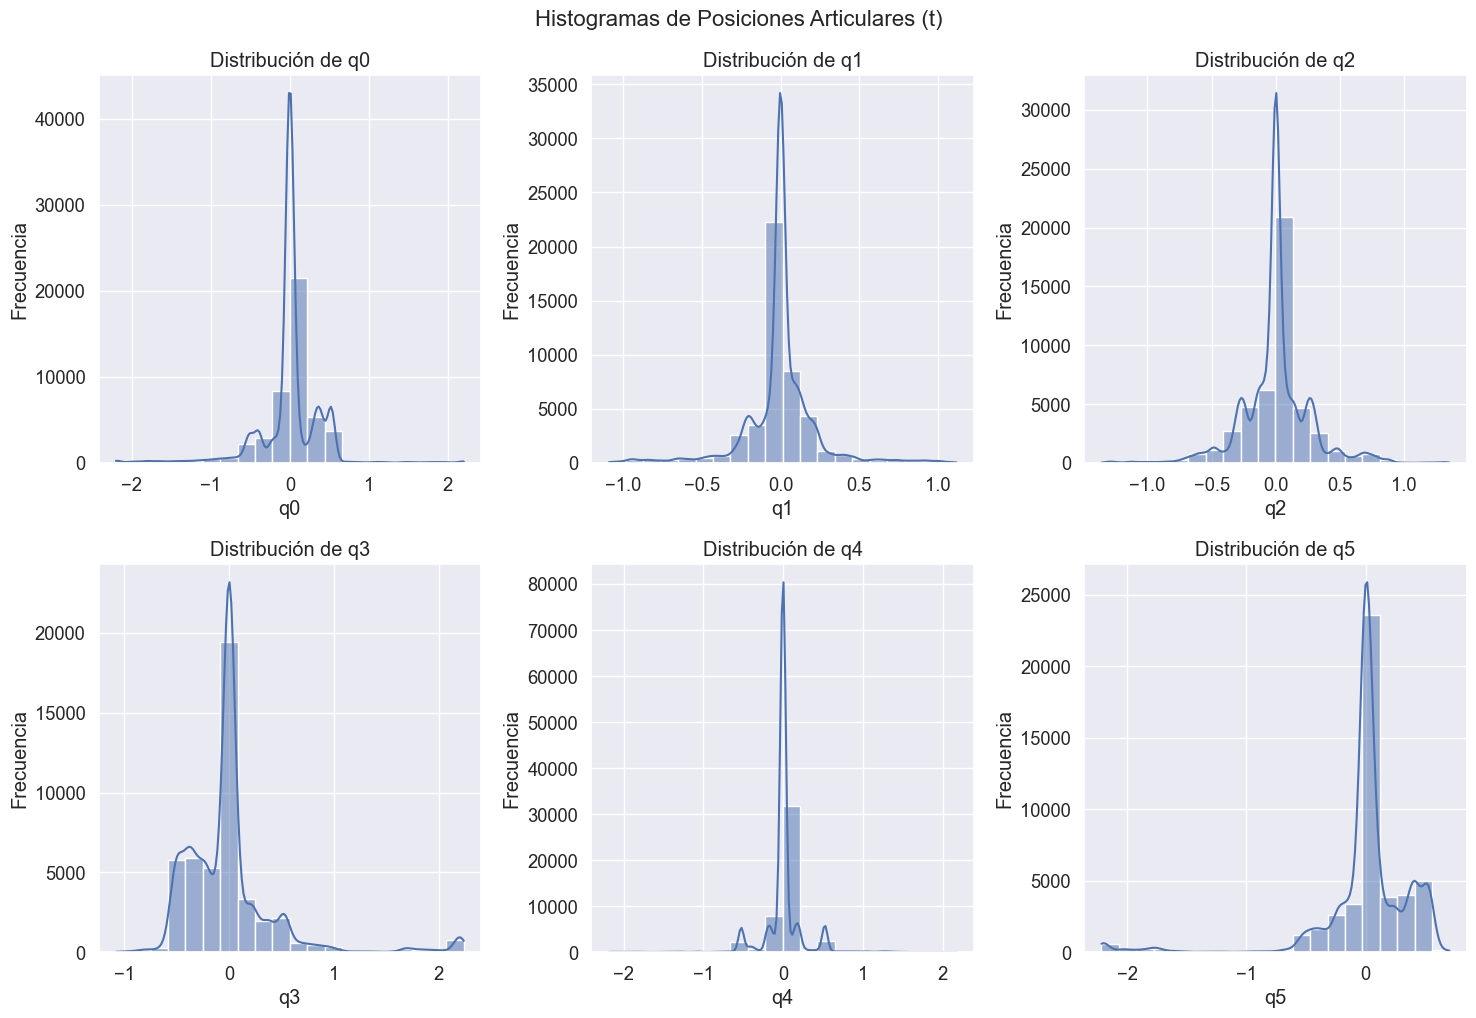

In [13]:
def plot_joint_histograms(df):
    variables_q = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5']
    positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

    fig = plt.figure(figsize=(15, 10))
    gs = GridSpec(2, 3, figure=fig)

    for var, pos in zip(variables_q, positions):
        ax = fig.add_subplot(gs[pos])
        if var in df.columns:
            sns.histplot(df[var], kde=True, ax=ax, bins=20)
            ax.set_title(f'Distribución de {var}')
            ax.set_xlabel(var)
            ax.set_ylabel('Frecuencia')
        else:
            print(f"Variable {var} no encontrada en el DataFrame")

    plt.tight_layout()
    plt.suptitle('Histogramas de Posiciones Articulares (t)', fontsize=16, y=1.02)
    plt.show()

plot_joint_histograms(df_final)

## Trayectoria Circular y Triangular

----
Referencia del conjunto de datos


OpenAXES Example Robot Dataset


Wölfel, Matthias; Drees, Alexander; Burgert, Oliver


Leibniz Universität Hannover – Institut für Mechatronische Systeme


Publicado en data.uni-hannover.de


DOI: 10.25835/0062786

----

Este conjunto contiene datos cinemáticos y dinámicos registrados durante la ejecución de movimientos controlados de un brazo robótico UR5, equipado con unidades de medición inercial (IMUs) desarrolladas bajo la plataforma OpenAXES. Los movimientos corresponden a trayectorias en el aire trazadas por el Tool Center Point (TCP) del brazo, con dos tipos de figura: círculo y triángulo, ejecutadas a cuatro velocidades lineales: 100 mm/s, 150 mm/s, 200 mm/s, y 250 mm/s.


In [25]:
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 8)

excel_path = r"Data\Gen1\openaxes-example-robot-dataset\robot\Complete.csv"
df = pd.read_csv(excel_path)
df

,X,Y,Z,RX,RY,RZ,q0,q1,q2,q3,...,q2_prev,q3_prev,q4_prev,q5_prev,100,150,200,250,Circle,Triangle
0,0.001007,-0.191371,1.001863,-0.005492,2.215752,-2.221980,0.000060,-1.570820,0.000036,-1.570808,...,0.000036,-1.570808,-0.000060,0.000048,True,False,False,False,True,False
1,0.000980,-0.191371,1.001863,-0.005506,2.215757,-2.221986,0.000036,-1.570772,0.000000,-1.570832,...,0.000036,-1.570808,-0.000060,0.000048,True,False,False,False,True,False
2,0.000986,-0.191371,1.001863,-0.005505,2.215733,-2.221961,0.000084,-1.570796,0.000048,-1.570832,...,0.000000,-1.570832,-0.000036,0.000048,True,False,False,False,True,False
3,0.000974,-0.191371,1.001863,-0.005518,2.215739,-2.221968,0.000072,-1.570760,0.000000,-1.570820,...,0.000048,-1.570832,-0.000060,0.000048,True,False,False,False,True,False
4,0.000988,-0.191371,1.001863,-0.005598,2.215727,-2.221955,0.000096,-1.570760,-0.000012,-1.570844,...,0.000000,-1.570820,-0.000048,0.000036,True,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39788,0.000949,-0.191371,1.001863,-0.005505,2.215686,-2.221914,0.000036,-1.570748,0.000012,-1.570736,...,0.000000,-1.570748,0.000048,-0.000024,False,False,False,True,False,True
39789,0.000972,-0.191371,1.001863,-0.005558,2.215685,-2.221913,0.000060,-1.570748,-0.000024,-1.570748,...,0.000012,-1.570736,0.000036,-0.000012,False,False,False,True,False,True
39790,0.000911,-0.191371,1.001863,-0.005439,2.215656,-2.221884,0.000036,-1.570712,0.000024,-1.570736,...,-0.000024,-1.570748,0.000036,0.000012,False,False,False,True,False,True
39791,0.000949,-0.191371,1.001863,-0.005571,2.215679,-2.221908,0.000036,-1.570724,-0.000024,-1.570748,...,0.000024,-1.570736,0.000036,0.000000,False,False,False,True,False,True


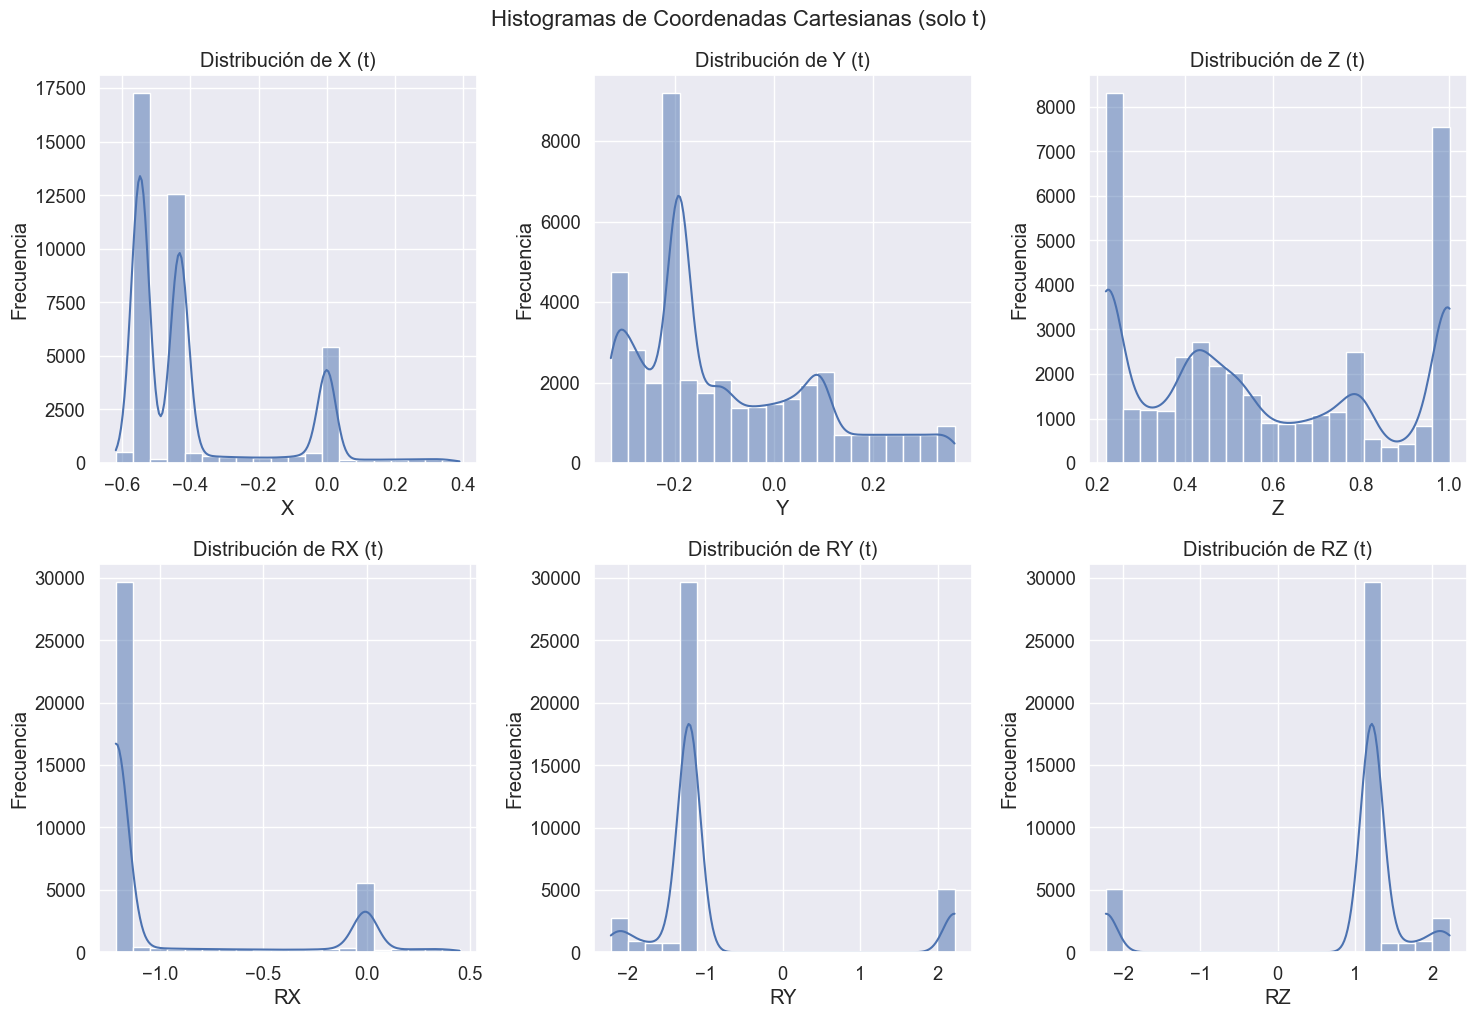

In [26]:
plot_cartesian_histograms(df)

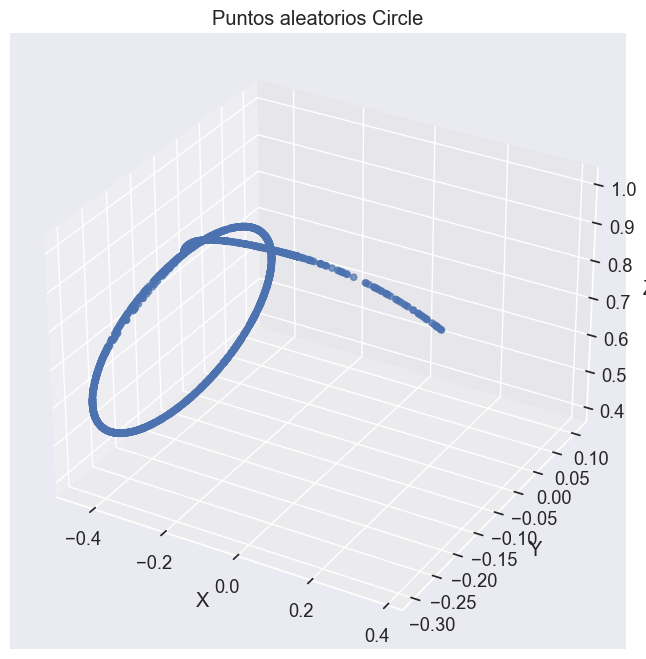

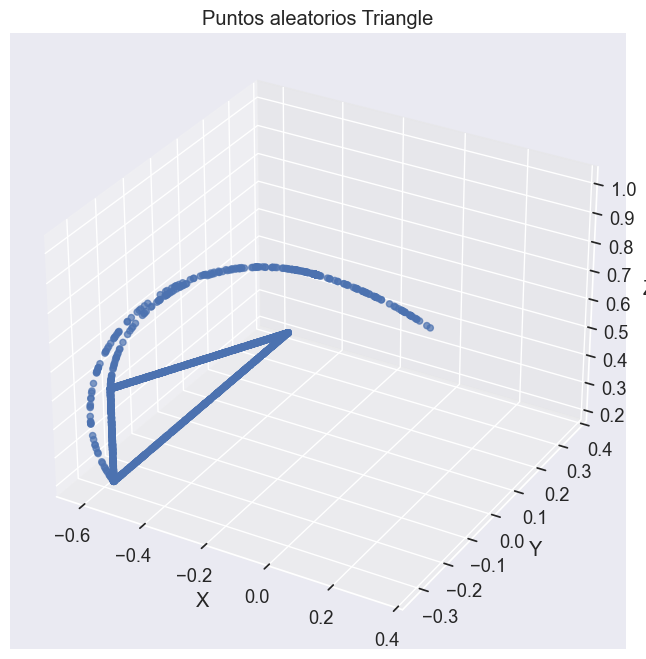

In [27]:
n = 2000 
if 'Circle' in df.columns:
    df_circle = df[df['Circle'] == True]
    if len(df_circle) > n:
        df_sample = df_circle.sample(n=n, random_state=42)
    else:
        df_sample = df_circle
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df_sample['X'], df_sample['Y'], df_sample['Z'], alpha=0.7)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Puntos aleatorios Circle')
    plt.show()

    
n = 2000 
if 'Triangle' in df.columns:
    df_triangle = df[df['Triangle'] == True]
    if len(df_triangle) > n:
        df_sample = df_triangle.sample(n=n, random_state=42)
    else:
        df_sample = df_circle
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df_sample['X'], df_sample['Y'], df_sample['Z'], alpha=0.7)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f'Puntos aleatorios Triangle')
    plt.show()

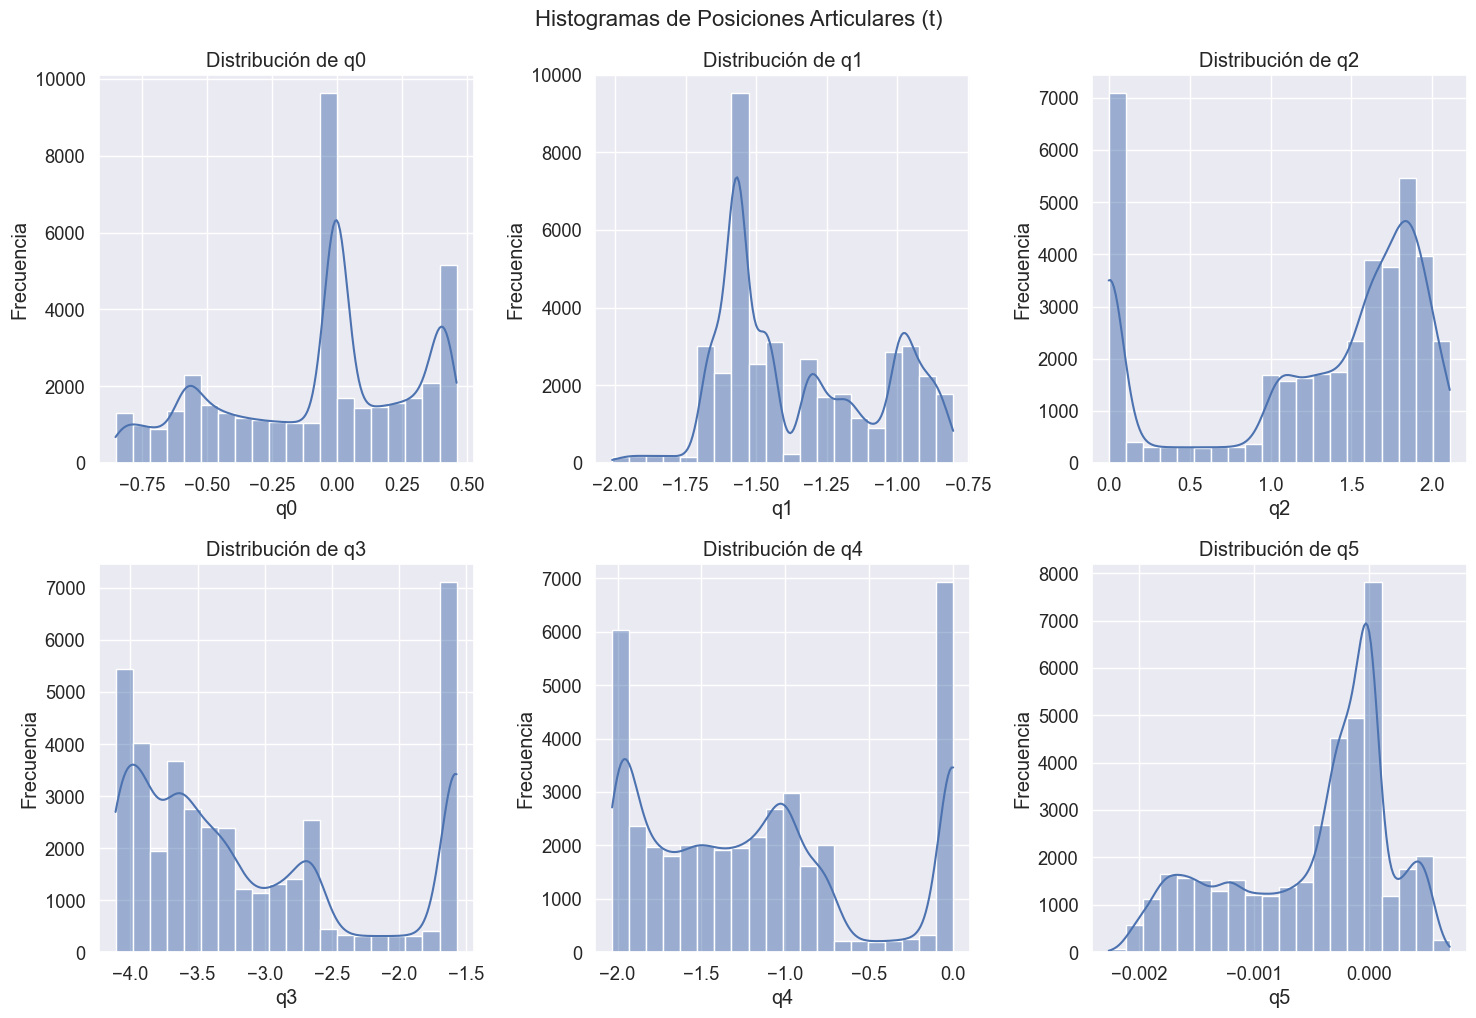

In [32]:
plot_joint_histograms(df)

## Peso y Velocidad

----
Referencia del conjunto de datos


Degradation Measurement of Robot Arm Position Accuracy


Autores: Intelligent Systems Division


Institución: National Institute of Standards and Technology (NIST)


Publicado en: nist.


DOI: No disponible

----

Este conjunto contiene mediciones cinemáticas y dinámicas capturadas durante la ejecución de trayectorias controladas por un brazo robótico UR5, con el objetivo de estudiar la degradación de su precisión posicional bajo condiciones reales de operación. Las trayectorias son ejecutadas por el Tool Center Point (TCP) en diversas configuraciones que combinan distintas cargas útiles, velocidades de operación y condiciones térmicas.

Condiciones experimentales incluidas:

Cargas útiles:

- 1.6 libras (≈ 0.73 kg)

- 4.5 libras (≈ 2.04 kg)

Velocidades de operación:

- Velocidad media (≈ 250 mm/s)

- Velocidad máxima (≈ 500 mm/s, según configuración del UR5)



In [17]:
import pandas as pd
import numpy as np

archivos = [
    "NISTdata.csv",
    "NISTdata_16lib.csv",
    "NISTdata_45lib.csv",
    "NISTdata_HalfSpeed.csv",
    "NISTdata_FullSpeed.csv"
]

ruta_base = r"Data\Gen2"

for nombre in archivos:
    archivo = f"{ruta_base}\\{nombre}"
    df = pd.read_csv(archivo)

    for i in range(6):
        col = f'q{i}'
        df[col] = np.deg2rad(df[col])
        df[col] = (df[col] + np.pi) % (2 * np.pi) - np.pi

    nombre_salida = nombre.replace(".csv", "_radianes.csv")
    df.to_csv(f"{ruta_base}\\{nombre_salida}", index=False)

    print(f"{nombre_salida} guardado.")




NISTdata_radianes.csv guardado.
NISTdata_16lib_radianes.csv guardado.
NISTdata_45lib_radianes.csv guardado.
NISTdata_HalfSpeed_radianes.csv guardado.
NISTdata_FullSpeed_radianes.csv guardado.


In [18]:
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 8)

excel_path = r"Data\Gen2\NISTdata_radianes.csv"
df = pd.read_csv(excel_path)
df

,X,Y,Z,RX,RY,RZ,q0,q1,q2,q3,...,dx,dy,dz,drx,dry,drz,16lib,45lib,HalfSpeed,FullSpeed
0,-0.637719,0.277536,0.756995,-1.075034,-1.130315,0.045502,-0.008187,-0.024342,0.017393,-0.048060,...,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,False,True,False,True
1,-0.637718,0.277543,0.756998,-1.075055,-1.130280,0.045504,-0.008187,-0.024342,0.017392,-0.048061,...,8.689837e-07,0.000006,0.000002,-0.000021,0.000036,2.844973e-06,False,True,False,True
2,-0.637723,0.277576,0.756968,-1.075093,-1.130323,0.045462,-0.008188,-0.024342,0.017393,-0.048060,...,-5.503548e-06,0.000033,-0.000030,-0.000038,-0.000044,-4.193587e-05,False,True,False,True
3,-0.637710,0.277562,0.756994,-1.075087,-1.130297,0.045515,-0.008188,-0.024342,0.017392,-0.048060,...,1.318451e-05,-0.000014,0.000025,0.000006,0.000026,5.274127e-05,False,True,False,True
4,-0.637732,0.277548,0.756979,-1.075060,-1.130323,0.045515,-0.008187,-0.024342,0.017393,-0.048060,...,-2.168058e-05,-0.000014,-0.000015,0.000028,-0.000026,2.365670e-07,False,True,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153653,-0.637693,0.277641,0.756968,-1.075215,-1.130206,0.045388,-0.008189,-0.024342,0.017393,-0.048060,...,-1.554122e-05,-0.000008,-0.000023,-0.000010,-0.000086,3.079707e-06,False,True,True,False
153654,-0.637692,0.277636,0.756976,-1.075210,-1.130163,0.045377,-0.008189,-0.024341,0.017392,-0.048061,...,5.573556e-07,-0.000005,0.000008,0.000005,0.000043,-1.047123e-05,False,True,True,False
153655,-0.637703,0.277618,0.756966,-1.075202,-1.130203,0.045438,-0.008189,-0.024342,0.017393,-0.048061,...,-1.131336e-05,-0.000018,-0.000010,0.000008,-0.000041,6.042005e-05,False,True,True,False
153656,-0.637667,0.277643,0.756993,-1.075157,-1.130165,0.045356,-0.008190,-0.024342,0.017393,-0.048061,...,3.633462e-05,0.000025,0.000027,0.000045,0.000038,-8.165273e-05,False,True,True,False


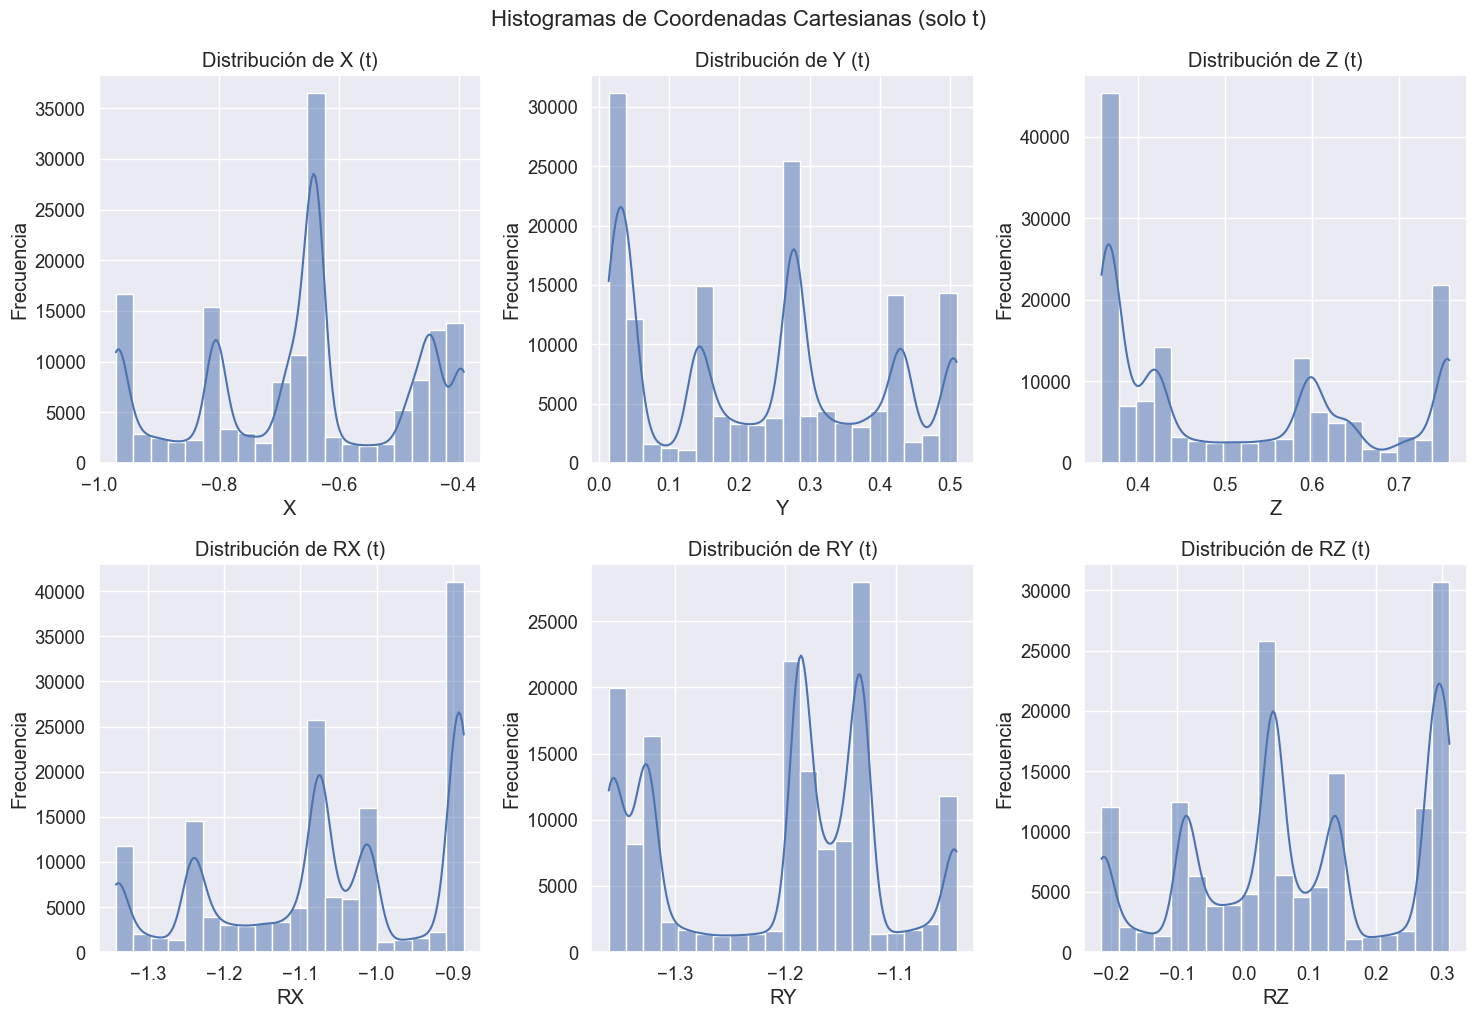

In [19]:
plot_cartesian_histograms(df)

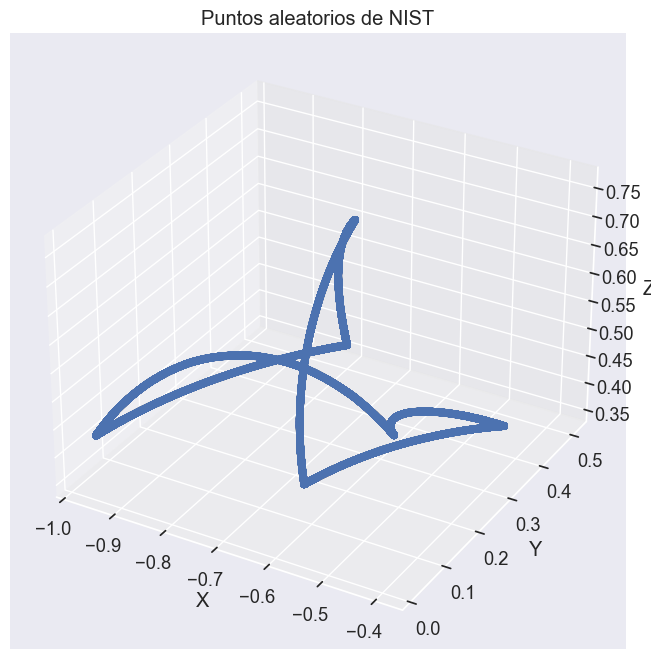

In [22]:
n = 100000
df_sample = df.sample(n=n, random_state=42) if len(df) > n else df
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_sample['X'], df_sample['Y'], df_sample['Z'], alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Puntos aleatorios de NIST')
plt.show()


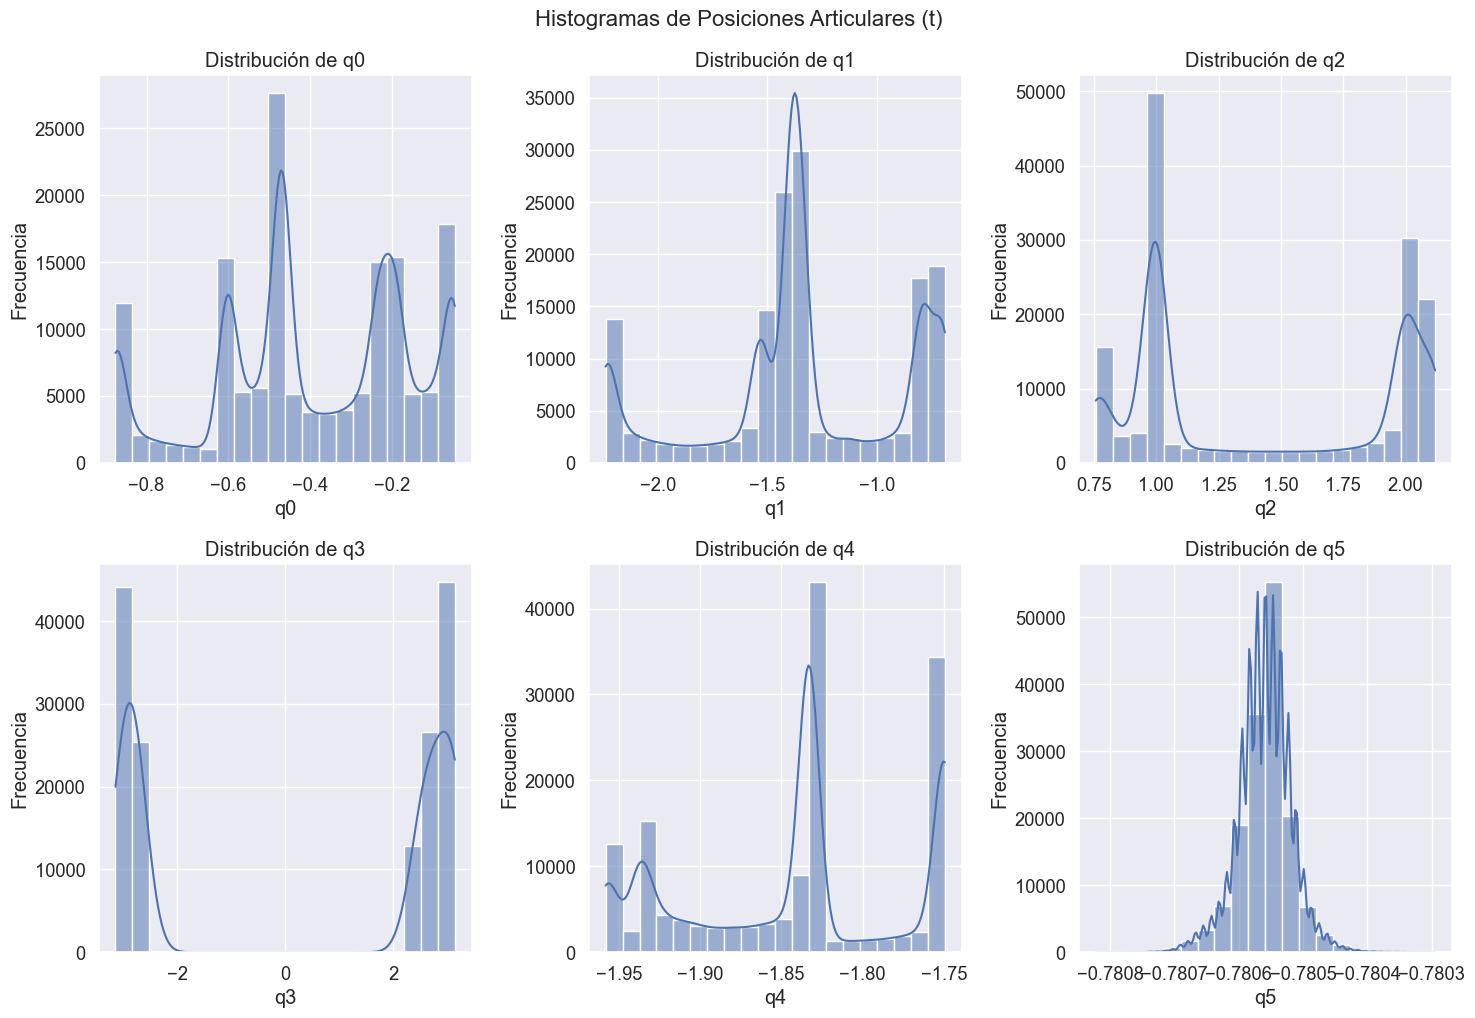

In [58]:
plot_joint_histograms(df)

## Aleatorios

In [9]:
plt.style.use('ggplot')
sns.set(font_scale=1.2)
plt.rcParams['figure.figsize'] = (14, 8)

excel_path = r"Data\3ros\Aleatorio.csv"
df = pd.read_csv(excel_path)
df

,X,Y,Z,RX,RY,RZ,q0,q1,q2,q3,...,Z_delta,RX_delta,RY_delta,RZ_delta,q0_prev,q1_prev,q2_prev,q3_prev,q4_prev,q5_prev
0,-0.399,-0.179,0.168,0,3.14,0,-2.4104,2.4003,2.3032,-3.1339,...,0.000,0.0,0.0,0.0,-2.4104,2.4003,2.3032,-3.1339,1.5719,-0.8396
1,-0.163,-0.132,0.073,0,3.14,0,-1.7732,2.3422,3.0091,-3.7808,...,-0.095,0.0,0.0,0.0,-2.4104,2.4003,2.3032,-3.1339,1.5719,-0.8396
2,-0.530,-0.364,0.158,0,3.14,0,-2.3311,2.5122,1.7065,-2.6490,...,0.085,0.0,0.0,0.0,-1.7732,2.3422,3.0091,-3.7808,1.5724,-0.2024
3,-0.262,-0.101,0.158,0,3.14,0,-2.2795,2.5401,2.7157,-3.6861,...,0.000,0.0,0.0,0.0,-2.3311,2.5122,1.7065,-2.6490,1.5720,-0.7603
4,-0.566,-0.544,0.226,0,3.14,0,-2.2056,2.8463,1.1157,-2.3921,...,0.068,0.0,0.0,0.0,-2.2795,2.5401,2.7157,-3.6861,1.5720,-0.7087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,-0.199,0.491,0.072,0,3.14,0,2.2104,-4.0928,2.0841,3.5786,...,-0.232,0.0,0.0,0.0,3.0270,-3.4945,2.0675,2.9962,1.5706,4.5978
795,-0.106,0.180,0.508,0,3.14,0,2.7954,-2.6361,1.9794,2.2260,...,0.436,0.0,0.0,0.0,2.2104,-4.0928,2.0841,3.5786,1.5695,3.7812
796,0.120,0.590,0.134,0,3.14,0,1.5937,-3.8685,1.8499,3.5894,...,-0.374,0.0,0.0,0.0,2.7954,-2.6361,1.9794,2.2260,1.5703,4.3662
797,-0.111,0.155,0.228,0,3.14,0,2.9667,-2.9646,2.7319,1.8019,...,0.094,0.0,0.0,0.0,1.5937,-3.8685,1.8499,3.5894,1.5692,3.1645


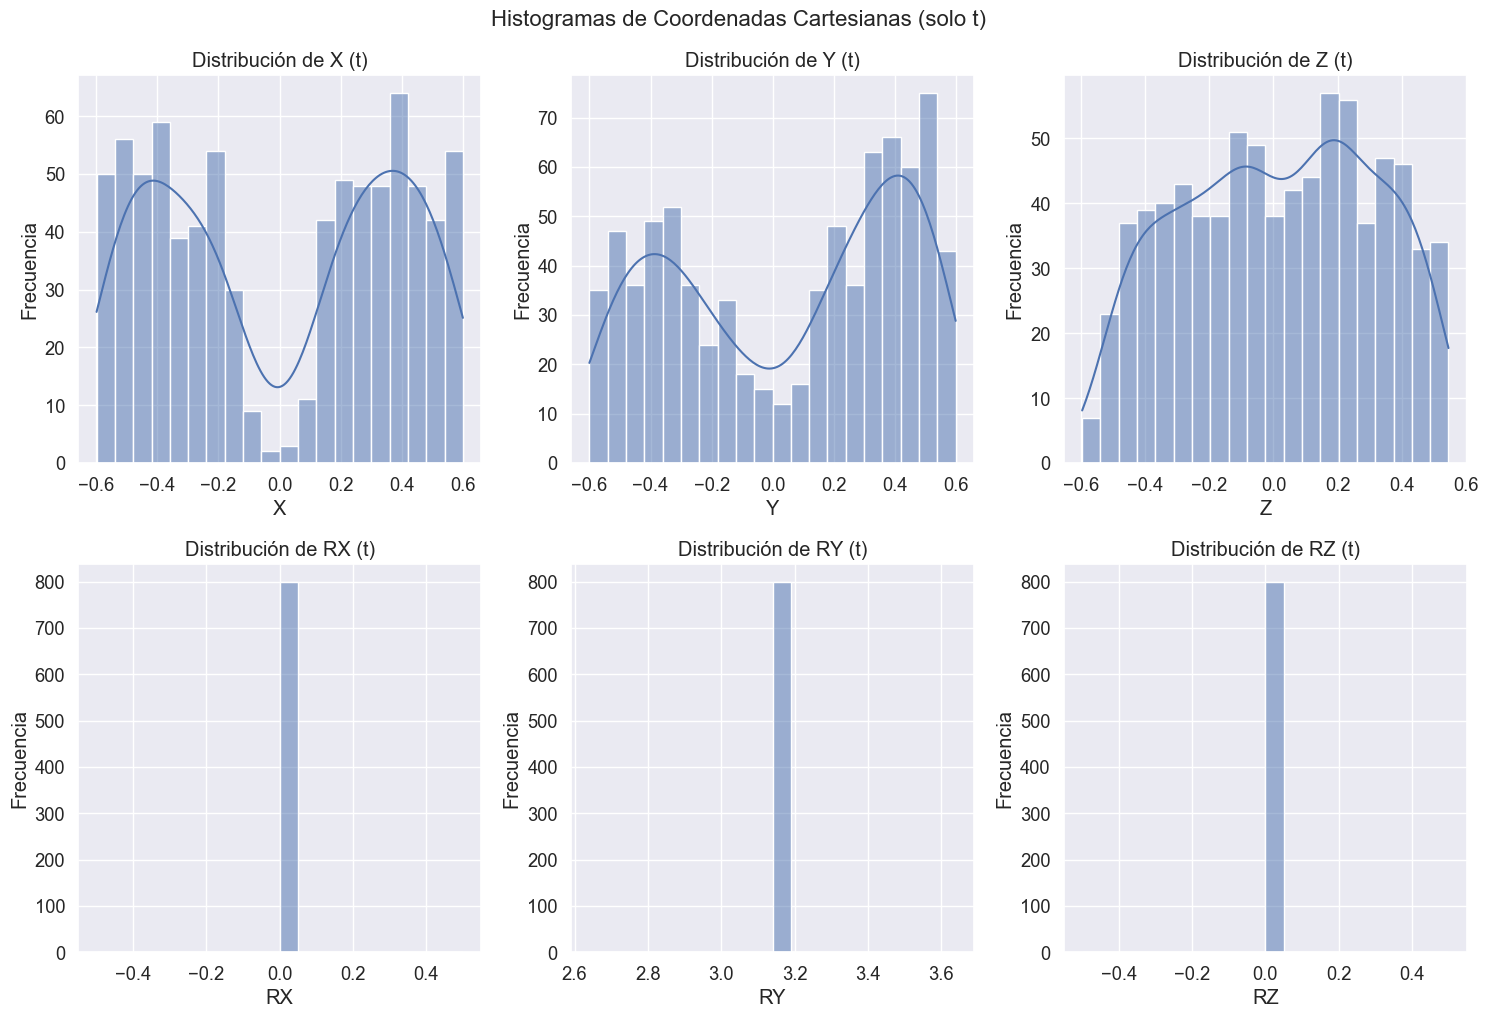

In [10]:
plot_cartesian_histograms(df)

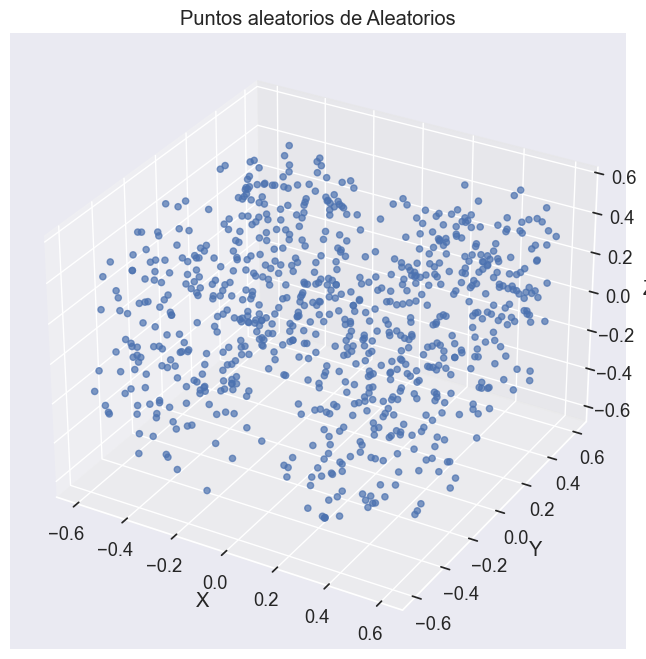

In [16]:
n = 799
df_sample = df.sample(n=n, random_state=42) if len(df) > n else df
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_sample['X'], df_sample['Y'], df_sample['Z'], alpha=0.7)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title(f'Puntos aleatorios de Aleatorios')
plt.show()

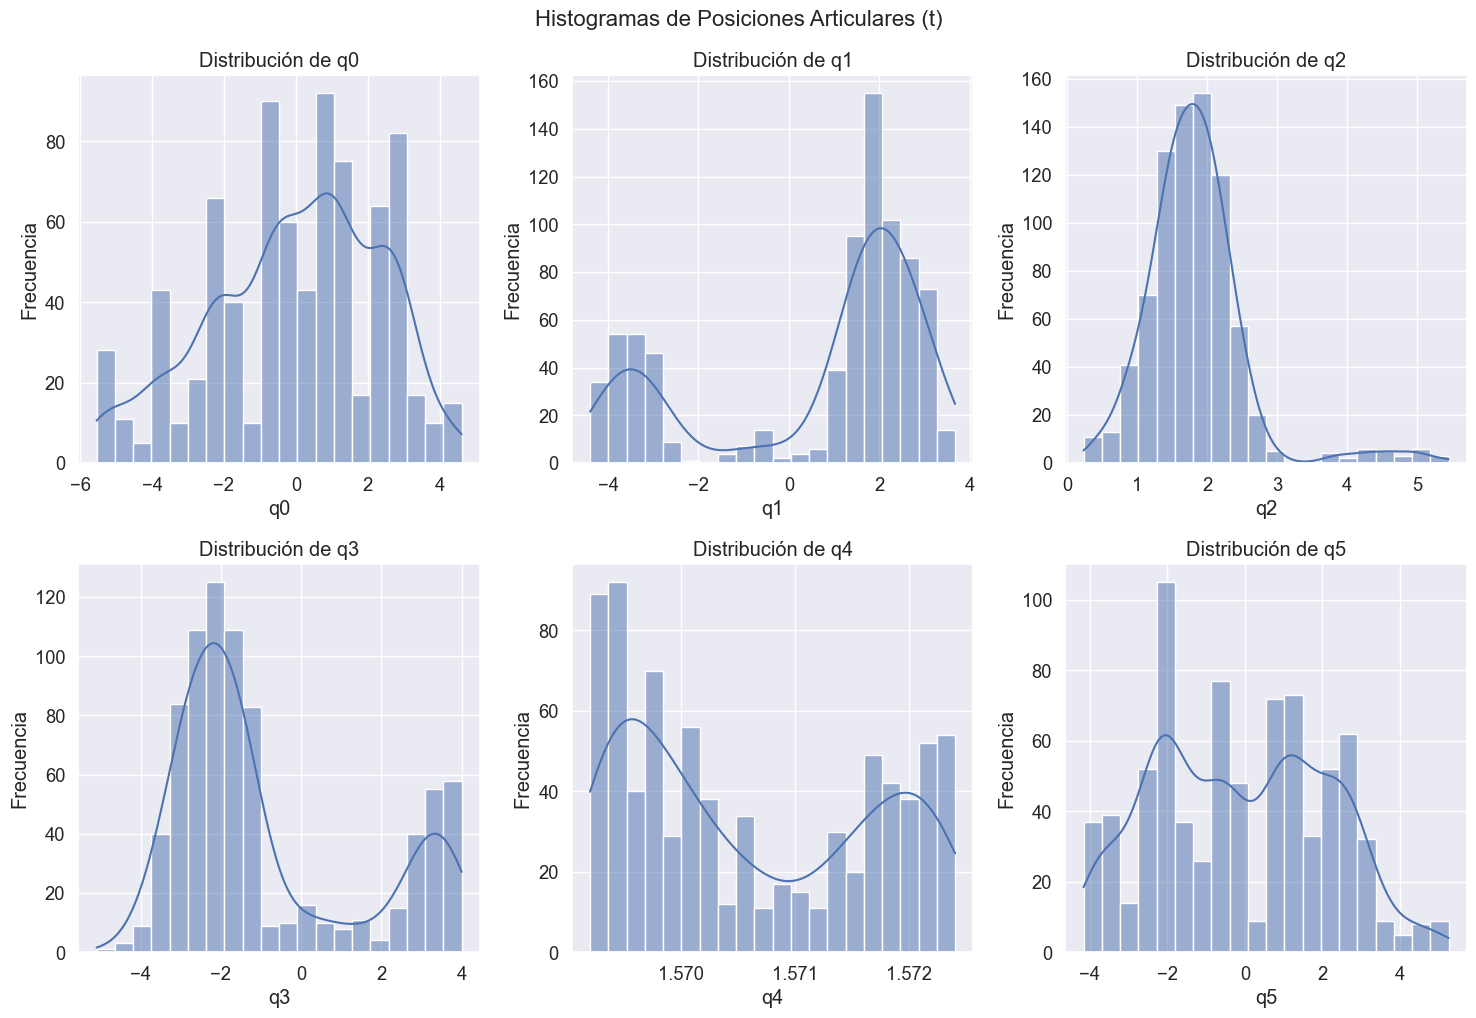

In [14]:
plot_joint_histograms(df)